In [1]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preparation import take_a_shower, clean_content_aravec
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')

In [126]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

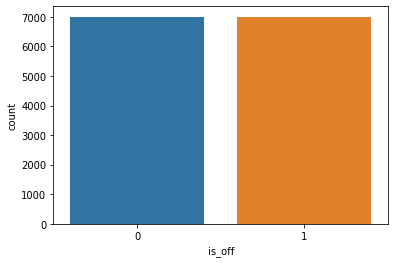

In [127]:
sns.countplot(x='is_off', data=data)

In [128]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [129]:
data.head()

,Comment,is_off
0,شوف حد ايران,1
1,شوف تيفي قوداتها الجن غي بلاتي يجي مكه,0
2,عجب يتفاوظون شعوب عربيه وعليهم وهيلا تعلم,0
3,هه هاد شوف تيفي اللي حطت مشا,0
4,الرزق ياتي تدري 🙌🏻❤️,0


# AraVec Embedding

In [130]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelEncoder
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from keras.utils import np_utils
import gensim

In [131]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
EMBEDDING_DIM = 100 # w2v, fastText; GloVe=50

In [132]:
path = './bin/aravec/tweets_sg_100'
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)

In [133]:
print(MAX_FEATURES)
print(EMBED_SIZE)

331679
100


In [134]:
# load data
# x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH = split_datasets(data, test_size=0.2, seed=42)

x = data.Comment.values
y = data.is_off.values
MAX_TEXT_LENGTH = get_max_length(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset splited.')
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
print("Max Length: " + str(MAX_TEXT_LENGTH))

Dataset splited.
Label categories: [0 1]
Max Length: 461


In [156]:
CLASSES_LIST

array([0, 1])

In [135]:
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 11200
Number of testing examples: 2800


In [136]:
train_y_cat[142]

array([1., 0.], dtype=float32)

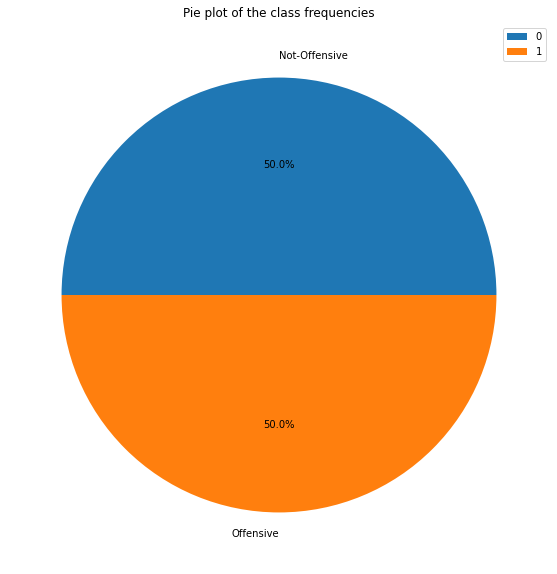

In [137]:
LABELS = (
    'Not-Offensive', 'Offensive'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS, autopct='%1.1f%%')
plt.legend(unique)
# plt.savefig("./img/stats_classes.png")
plt.show();

In [138]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
# MAX_TEXT_LENGTH = 100

Original sequence length : 461


In [139]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    DOC
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = LSTM(units=32, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
    
    model = LSTM(units=16, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
        
    model = Flatten()(model)
        
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(1, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)

#     model = Sequential()
#     model.add(Input(shape=(max_length,)))
#     model.add(Embedding(input_dim=len(word_index)+1,
#                         output_dim=vocab_dim,
#                         trainable=False,
#                        weights=[embedding_weights]))
    
#     model.add(LSTM(32, return_sequences=True, return_state=False))
#     model.add(Dropout(0.1))
    
#     model.add(LSTM(16, return_sequences=True, return_state=False))
#     model.add(Dropout(0.1))
    
#     model.add(Flatten())
    
#     model.add(Dense(200, activation='relu'))
#     model.add(Dropout(0.1))
    
#     model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model

In [140]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 461)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 461, 100)          4453100   
_________________________________________________________________
lstm_12 (LSTM)               (None, 461, 32)           17024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 461, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 461, 16)           3136      
_________________________________________________________________
dropout_18 (Dropout)         (None, 461, 16)           0         
_________________________________________________________________
flatte

In [141]:

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs):
    """
    DOC 
    """
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
    return history, model

In [153]:
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_test[:, :MAX_TEXT_LENGTH],
                               y_train, y_test,
                               batch_size=500, epochs=150)

Epoch 1/150
18/18 [==============================] - 5s 253ms/step - loss: 5.9498e-08 - accuracy: 0.5109 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 2/150
18/18 [==============================] - 4s 240ms/step - loss: 5.9498e-08 - accuracy: 0.5081 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 3/150
18/18 [==============================] - 4s 246ms/step - loss: 5.9498e-08 - accuracy: 0.5115 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 4/150
18/18 [==============================] - 5s 253ms/step - loss: 5.9498e-08 - accuracy: 0.5071 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 5/150
18/18 [==============================] - 5s 260ms/step - loss: 5.9498e-08 - accuracy: 0.5080 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 6/150
18/18 [==============================] - 4s 248ms/step - loss: 5.9498e-08 - accuracy: 0.5073 - val_loss: 5.9179e-08 - val_accuracy: 0.5018
Epoch 7/150
18/18 [==============================] - 5s 263ms/step - loss: 5.9498e-08 - accura

In [143]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss_val, accuracy_val = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))
print("Testing Loss:  {:.4f}".format(loss_val))

350/350 [==============================] - 14s 40ms/step - loss: 5.9434e-08 - accuracy: 0.5060
Training Accuracy: 0.5060
Training Loss: 0.0000
88/88 [==============================] - 3s 39ms/step - loss: 6.0286e-08 - accuracy: 0.5007
Testing Accuracy:  0.5007
Testing Loss:  0.0000


In [145]:
y_pred = model.predict(x_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

88/88 [==============================] - 3s 39ms/step


In [146]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1384
           1       0.00      0.00      0.00      1416

    accuracy                           0.49      2800
   macro avg       0.25      0.50      0.33      2800
weighted avg       0.24      0.49      0.33      2800



In [151]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

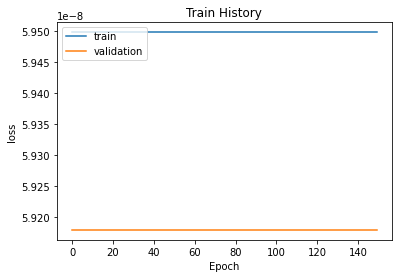

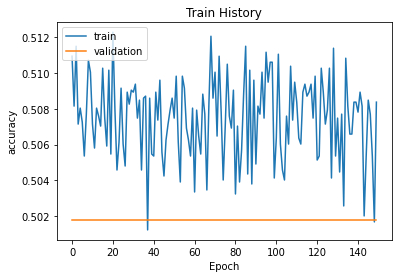

In [154]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss')

show_train_history(history,'accuracy','val_accuracy')